<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Set-Environment-Parameters" data-toc-modified-id="Set-Environment-Parameters-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Set Environment Parameters</a></span><ul class="toc-item"><li><span><a href="#Set-Environment-with-Parameters" data-toc-modified-id="Set-Environment-with-Parameters-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Set Environment with Parameters</a></span></li></ul></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Main</a></span></li></ul></div>

# Preamble

## Imports

In [1]:
from simfection.population_engine import PopulationEngine
from simfection.settings import SimfectionSettings
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Set Environment Parameters

In [2]:
number_of_trials = 10**4

In [3]:
# Window for rolling average in final plot
rolling_window = 50

In [4]:
# For sum(initial_states) < 1, susceptible rate set to 1 - sum(initial_states)
initial_states = {
        'inf': 0.12,
        'dead': 0.03,
    }

### Set Environment with Parameters

In [5]:
# Turn off logger
logging.disable(logging.CRITICAL)

In [6]:
settings = SimfectionSettings()

In [7]:
settings.set_setting(
    'initial_states',
    initial_states
)

{'inf': 0.12, 'dead': 0.03}

In [8]:
sns.set()

# Main

To test the efficacy of the `PopulationEngine` with respect to synthesizing the initial states for the population, we perform the initial states synthesis `number_of_trials`  of times.

Each time, we measure the distribution of states and save to a list.

In [9]:
population = PopulationEngine(settings)

In [10]:
%%time
measurements = []
for _ in range(number_of_trials):
    population.synthesize_population()
    states = population._df.state.value_counts(normalize=True).to_dict()
    measurements.append(
        {
            'dead':states.get('dead',0),
            'sus':states.get('sus',0),
            'inf':states.get('inf',0)
        }
    )

CPU times: user 18.8 s, sys: 194 ms, total: 19 s
Wall time: 19.9 s


Here, convert the list of measurements to a `pandas` DataFrame.

In [11]:
measurements = pd.DataFrame(measurements)

Plot the rolling average of each initial state with a window size of `rolling_window`. The red lines indicate the average of all trials. The target initial states are given in the title.

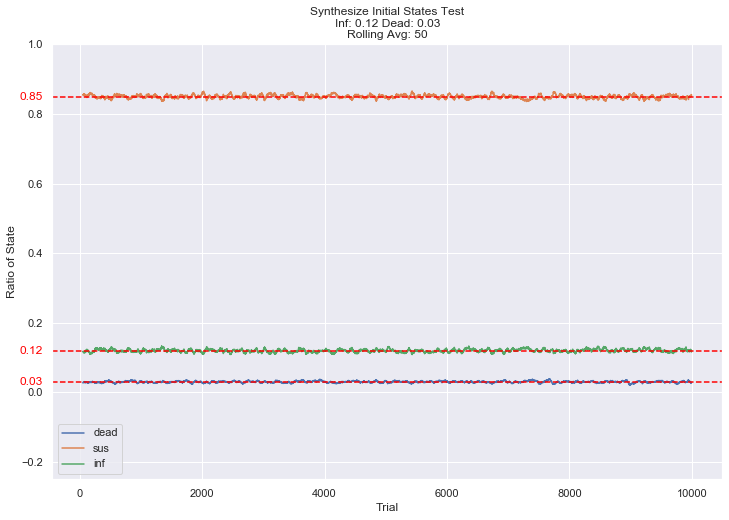

In [12]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
for col in measurements.columns:
    sns.lineplot(
        x='index',
        y=col,
        label=col,
        data=(
            measurements
            .rolling(
                rolling_window
            )
            .mean()
            .reset_index()
        ),
        ax=ax
    )
    ax.axhline(
        y=measurements[col].mean(),
        linestyle='--',
        color='red'
    )
    trans = transforms.blended_transform_factory(
        ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,measurements[col].mean(), "{:.2f}".format(measurements[col].mean()), color="red", transform=trans, 
            ha="right", va="center")
_ = ax.set(
    ylim=[-0.25,1],
    xlabel='Trial',
    ylabel='Ratio of State',
    title='Synthesize Initial States Test\nInf: {inf} Dead: {dead}\nRolling Avg: {window}'.format(
        inf=population.initial_states['inf'],
        dead=population.initial_states['dead'],
        window=rolling_window
    )
)
